# Notebook sur l'homograghie

Dans ce notebook, on va voir comment utiliser un objet dont on connait ses réelles dimensions pour appliquer une homographie et générer de nouvelles images d'un point de vue différent à l'aide de projections

**Plan:**
1. Récupération des points de référence
2. Homographie
3. Première méthode d'estimation de la distance entre les joueurs et la table

## Résultats attendus de l'homographie

<img src="utils/attentes_homographie.PNG" width=500 height=500 />

### 0. Import

In [138]:
import cv2
import os
import subprocess
import json
import pandas as pd
import csv
import ipywidgets
#from IPython.display import Image, display
import IPython.display
import PIL
from ipyfilechooser import FileChooser
from moviepy.editor import VideoFileClip
from ntt.frames.frame_extraction import extract_first_frame
from utils.fonction import file_chooser

### 1. Récupération des points de référence

On affiche une image sur laquelle on va sélectionner les 4 coins de la table.
(Les fonctions pour l'homographie utiliseront les 4 derniers cliques comme coin de la table)
L'ordre dans lequel on annote les coins de la table est important

<img src="utils/ordre_annotation_coins_table.PNG" width=300 height=300 />

#### 1.1. Sélection de la vidéo

On choisi la vidéo sur laquelle on va vouloir travailler

In [153]:
def file_chooser(type_fichier):
    fdialog_video = FileChooser(
        os.getcwd(),
        filename='test.txt',
        title='<b>FileChooser example</b>',
        show_hidden=False,
        select_default=True,
        show_only_dirs=False
    )
    
    if type_fichier == 'image':
        extension = ['*.jpg', '*.png','*.PNG','*.jpeg']
    if type_fichier == 'video':
        extension = ['*.mp4', '*.avi']
    
    display(fdialog_video)

    # Get the selected value
    fdialog_video.selected

    # Callback example
    def change_title(chooser):
        chooser.title = '<b>Sélection effectuée</b>'

    # Register callback function
    fdialog_video.register_callback(change_title)
    # Set or change the title
    fdialog_video.title = '<b>Selectionner une '+type_fichier+'</b>'
    # Show hidden files, change rows to 10, and hide folder icons
    fdialog_video.show_hidden = True
    fdialog_video.rows = 10
    fdialog_video.dir_icon = None
    # Change folder icon to `os.sep` and append it to the folder name
    fdialog_video.dir_icon = os.sep
    fdialog_video.dir_icon_append = True
    # Switch to folder-only mode
    fdialog_video.show_only_dirs = True
    # Switch back to standard mode
    fdialog_video.show_only_dirs = False
    # Set multiple file filter patterns (uses https://docs.python.org/3/library/fnmatch.html)
    fdialog_video.filter_pattern = extension
    # Change the default path and filename
    fdialog_video.default_path = os.path.abspath(os.getcwd())
    fdialog_video.default_filename = 'readme.md'
    # Reset to defaults and clear the selected value
    fdialog_video.reset()
    return(fdialog_video)

In [147]:
fdialog_video = file_chooser('video')

FileChooser(path='C:\Users\ReViVD\Documents\GitHub\tuto-video-tracking', filename='test.txt', title='<b>FileCh…

#### 1.2. Extraction de la première frame

On extrait la première image de la vidéo, car elle contient la table et c'est sur cette image que l'on va travailler

In [89]:
#Extraction de la première frame d'une table
if not os.path.isdir('output'):
    os.mkdir('output')
frame_path = os.path.join('output','frames')

if not os.path.isdir(frame_path):
    os.mkdir(frame_path)

extract_first_frame(
        video_path_in=os.path.join(os.path.split(fdialog_video.selected)[0]),
        video_name_in=os.path.split(fdialog_video.selected)[1],
        frame_path_out=os.path.join('sample'),
        frame_name_out=os.path.split(fdialog_video.selected)[1][:-4]+'_frame1.jpg',
    )

'sample'

#### 1.3. Sélection de l'image

On sélectionne l'image que l'on vient d'extraire

In [152]:
fdialog = file_chooser('image')

FileChooser(path='C:\Users\ReViVD\Documents\GitHub\tuto-video-tracking', filename='test.txt', title='<b>FileCh…

#### 1.4. Sélection des 4 coins de la table

Après avoir choisi l'image que l'on voulait utiliser pour sélectionner les coins de la table, il suffit de cliquer directement sur les 4 coins de la table (en respectant le bon ordre) pour les sélectionner

<IPython.core.display.Javascript object>


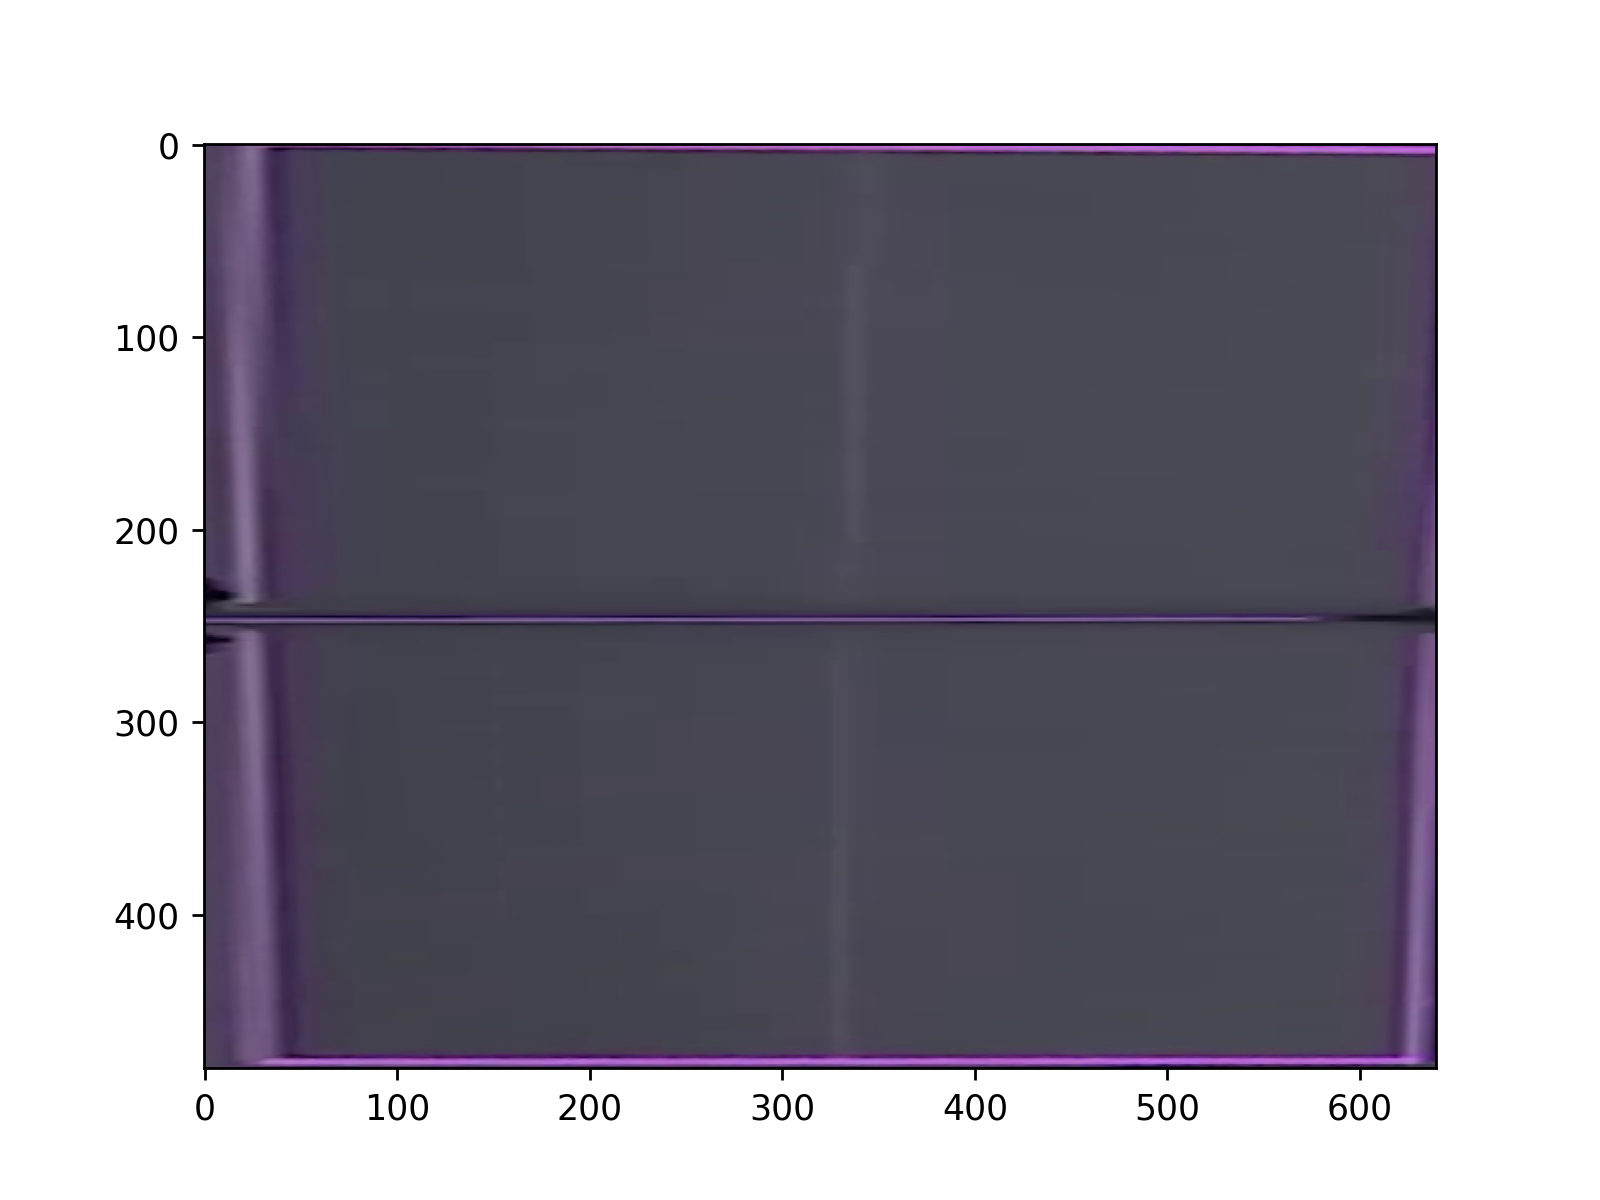

In [154]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as wdg  # Using the ipython notebook widgets

chemin_image = fdialog.selected#os.path.join('test','1th_frame.jpg') #A DEFINIR

if ((os.path.isfile(chemin_image)) and (os.path.split(chemin_image)[-1][-4:] in ['.jpg', '.png'])):
    
    # Create a random image
    a = np.random.poisson(size=(12,15))
    fig = plt.figure()
    plt.imshow(cv2.cvtColor(cv2.imread(chemin_image), cv2.COLOR_BGR2RGB))

    # Create and display textarea widget
    txt = wdg.Textarea(
        value='',
        placeholder='',
        description='event:',
        disabled=False
    )
    liste_points = []
    # Define a callback function that will update the textarea
    def onclick(event):
        txt.value = str(event)  # Dynamically update the text box above
        liste_points.append(str(event).split('xydata=(')[1].split(')')[0].replace(' ',''))

    # Create an hard reference to the callback not to be cleared by the garbage collector
    ka = fig.canvas.mpl_connect('button_press_event', onclick)
    
else:
    print('Ce n\'est pas une image qui a été choisie')

### 2. Homographie

A l'aide des quatre coin de la table, on va pouvoir créer une vue du dessus uniquement de la table.
Les dimensions de la table étant connues (standard), on peut à l'aide des coins que l'on a annotés faire une correspondance et une homographie

In [92]:
#Enregistrement des coordonnées de la table dans un fichier json
dictionary = {
    "homography":{
    "srcPts": [[int(float(liste_points[-4].split(',')[0])),int(float(liste_points[-4].split(',')[1]))],
               [int(float(liste_points[-3].split(',')[0])),int(float(liste_points[-3].split(',')[1]))],
               [int(float(liste_points[-2].split(',')[0])),int(float(liste_points[-2].split(',')[1]))],
               [int(float(liste_points[-1].split(',')[0])),int(float(liste_points[-1].split(',')[1]))]]}
}
with open(os.path.join("output","points_table.json"), "w") as outfile:
    json.dump(dictionary, outfile)

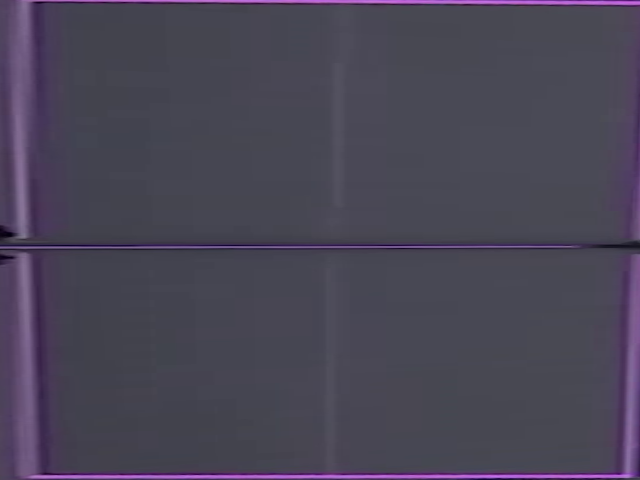

In [116]:
#Récupération des coordonnées des points de la table dans le json créé

def homographie_image(chemin_image,dossier_sauvegarder,liste_points,afficher_image=True):
    """
        Fonction permettant de faire une homographie à partir d'une image
        Entrée: le chemin de l'image, le dossier où l'on veut sauvegarder l'image, la liste des points de la table, un booléen pour savoir si on affiche l'image
        Sortie: enregistrement de l'homographie
    """
    if not os.path.isdir(dossier_sauvegarder):
        os.mkdir(dossier_sauvegarder)
    if len(liste_points) >= 4:
        pt1 = [int(float(liste_points[-4].split(',')[0])),int(float(liste_points[-4].split(',')[1]))]
        pt2 = [int(float(liste_points[-3].split(',')[0])),int(float(liste_points[-3].split(',')[1]))]
        pt3 = [int(float(liste_points[-2].split(',')[0])),int(float(liste_points[-2].split(',')[1]))]
        pt4 = [int(float(liste_points[-1].split(',')[0])),int(float(liste_points[-1].split(',')[1]))]
        
        img = cv2.cvtColor(cv2.imread(chemin_image), cv2.COLOR_BGR2RGB)
        pts_src = np.float32([[pt1[0],pt1[1]],[pt2[0],pt2[1]],[pt3[0],pt3[1]],[pt4[0],pt4[1]]]).reshape(-1,1,2)
        pts_dst = np.float32([[0,0],[640,0],[640,480],[0,480]]).reshape(-1,1,2) #On choisi les points de destination de tel sorte à avoir une vude du dessus où 1cm = 1pixel
        H = cv2.getPerspectiveTransform(pts_src, pts_dst)
        img = cv2.warpPerspective(img, H, (640,480))
        if afficher_image:
            IPython.display.display(PIL.Image.fromarray(img))
        cv2.imwrite(os.path.join(dossier_sauvegarder,os.path.split(chemin_image)[1]),img)
        
        
homographie_image(chemin_image,os.path.join('output','homographie'),liste_points)

### 3. Enregistrer vidéo homographie

A partir de la vidéo complète, on va pouvoir énérer pour chaque frame une homographie puis créer une vidéo

#### 3.1. Extraction des frames de la vidéo

In [118]:
#Lecture de la vidéo
video_name = fdialog_video.selected

vidcap = cv2.VideoCapture(video_name)
#Extraction les frames d'une vidéo
if not os.path.isdir('output'):
    os.mkdir('output')
frame_path = os.path.join('output','frames')

if not os.path.isdir(frame_path):
    os.mkdir(frame_path)
    
success, image = vidcap.read()
i = 0
while success != False:
    #Lecture des frames
    success, image = vidcap.read()
    
    #Sauvegarder les frames
    if success:
        cv2.imwrite(os.path.join(frame_path, str(i) + ".jpg"), image)
    else:
        break
    
    i += 1

#### 3.2 Création de l'homographie pour chaque frame

In [119]:
#Faire l'homographie sur toutes les images d'un dossier et Sauvegarder les images


#sauvegarder_img_homographie(os.path.join('output','frames'),liste_points)

#### 3.3. Création de la vidéo à l'aide de chaque frame

In [122]:
#Enregistrer une vidéo à l'aide des images

    
"""enregistrer_video_d_images(os.path.join('output','homographie'),'homographie.avi')"""

### 4. Visualiser la vidéo

On va sélectionner la vidéo de l'homographie pour la visualiser

#### 4.1. Sélection

In [121]:

fdialog_vid = file_chooser('video')

FileChooser(path='C:\Users\ReViVD\Documents\GitHub\tuto-video-tracking', filename='test.txt', title='<b>FileCh…

#### 4.2. Visualisation

In [85]:
clip = VideoFileClip(fdialog_vid.selected)
clip.ipython_display(width=600)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
